# Time Based Utilities and Drift Removal

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from cmip6_preprocessing.utils import google_cmip_col
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [2]:
from dask_gateway import Gateway
g = Gateway()
running_clusters = g.list_clusters()
print(running_clusters)
for c in running_clusters:
    # g.stop_cluster()
    cluster = g.connect(c.name)
    cluster.close()
print(running_clusters)

[]
[]


In [3]:
from distributed import Client
from dask_gateway import GatewayCluster
cluster = GatewayCluster()
cluster.scale(10)
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.9d3d525b3ad3455f9bdb3ff29ddf281e Dashboard: /services/dask-gateway/clusters/prod.9d3d525b3ad3455f9bdb3ff29ddf281e/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Loading example data

In [5]:
zkwargs = {'consolidated':True, 'use_cftime':True}
kwargs = {'zarr_kwargs':zkwargs, 'preprocess':combined_preprocessing, 'aggregate':False}

col = google_cmip_col()


cat = col.search(source_id='CanESM5-CanOE', variable_id='thetao')


ddict_historical = cat.search(experiment_id='historical').to_dataset_dict(**kwargs)
ddict_ssp585 = cat.search(experiment_id='ssp585').to_dataset_dict(**kwargs)
ddict_picontrol = cat.search(experiment_id='piControl').to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Visulalizing branching from the control run

In [23]:
ds_control = ddict_picontrol['CMIP.CCCma.CanESM5-CanOE.piControl.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piControl/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']
ds_historical = ddict_historical['CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']
ds_ssp585 = ddict_ssp585['ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5-CanOE/ssp585/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']

In [7]:
# Pick a random location in x/y/z space
roi = {'x':100,'y':220, 'lev':30}

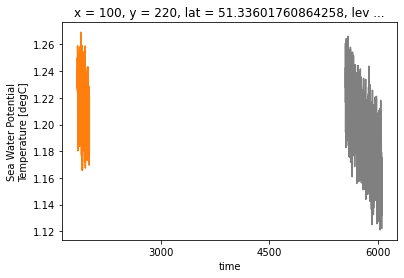

In [34]:
# ok lets just plot them together
ds_control.isel(**roi).thetao.plot(color='0.5')
ds_historical.isel(**roi).thetao.plot(color='C1')

Hmm well that doesnt look good. Its because the control run follows a different time convention. But we can check when the run was branched out exactly by looking at the metadata of the historical run:

In [9]:
{k:v for k,v in ds_historical.attrs.items() if 'parent' in k}

{'CCCma_parent_runid': 'canoecpl-007',
 'YMDH_branch_time_in_parent': '5550:01:01:00',
 'branch_time_in_parent': 1350500.0,
 'parent_activity_id': 'CMIP',
 'parent_experiment_id': 'piControl',
 'parent_mip_era': 'CMIP6',
 'parent_source_id': 'CanESM5-CanOE',
 'parent_time_units': 'days since 1850-01-01 0:0:0.0',
 'parent_variant_label': 'r1i1p2f1'}

And of course there is a tool in here that makes translating these a bit easier. We can just convert time conventions from child to parent or vice versa.

In [10]:
from cmip6_preprocessing.drift_removal import unify_time
# the default will adjust the time convention from the first input (`parent`) to the second (`child`)
ds_control_adj, ds_historical_adj = unify_time(ds_control, ds_historical)

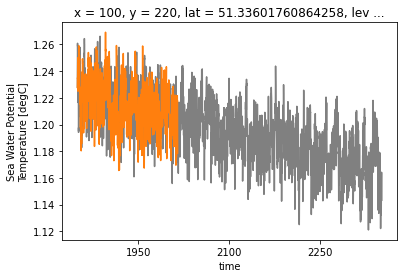

In [11]:
# ok lets just plot them together
ds_control_adj.isel(**roi).thetao.plot(color='0.5')
ds_historical_adj.isel(**roi).thetao.plot(color='C1')

That looks more sensible, but with all the wiggles its a bit tough to see. Since this run seems to be branched of at the first time step of the control ouput (the run is probably much longer, but not all data was provided to the archive), lets just cut to the first couple of timesteps to check in more detail. 

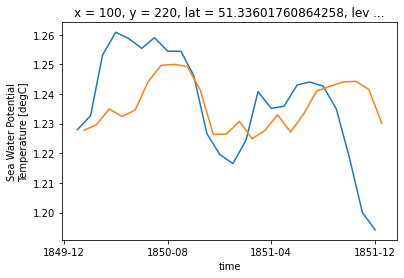

In [12]:
# ok lets just plot them together
ds_control_adj.isel(**roi, time=slice(0,24)).thetao.plot()
ds_historical_adj.isel(**roi, time=slice(0,24)).thetao.plot()

That looks pretty good, but the values are slightly shifted. This is due to the fact that for the 'untouched' CMIP6 monthly data uses a timestamp in the 'middle' of the month, whereas our adustment uses the start of the month. We can quickly adjust that:

In [13]:
from cmip6_preprocessing.drift_removal import replace_time
# with the defaults it will just replace the dates with new ones which have time stamps at the beginning of the month.
ds_historical_adj = replace_time(ds_historical_adj) 

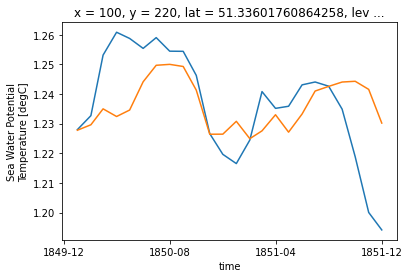

In [14]:
# ok lets just plot them together again
ds_control_adj.isel(**roi, time=slice(0,24)).thetao.plot()
ds_historical_adj.isel(**roi, time=slice(0,24)).thetao.plot()

BINGO

OK now lets look at all the members: 

In [15]:
for name, ds in ddict_historical.items():
    print(name, ds.attrs['branch_time_in_parent'])

CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1350500.0
CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1387000.0
CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1368750.0


Hmmm, these were all branched out at a different time! This is actually quite common, but it means to visualize these we will have to convert the time into the conventions of the parent (control) run. Thats pretty easy though!

distributed.client - WARNING - Couldn't gather 7 keys, rescheduling {"('getitem-cd6e16d2b7127e97503588b6cc01f098', 21)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 24)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 35)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 18)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 19)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 25)": (), "('getitem-cd6e16d2b7127e97503588b6cc01f098', 14)": ()}


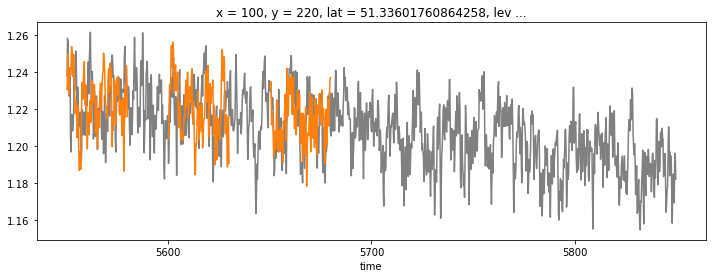

In [16]:
# replace the timestamp with the first of the month for the control run and plot
# we will also average the data yearly to remove some of the visual noise

plt.figure(figsize=[12,4])
replace_time(ds_control).isel(**roi).thetao.coarsen(time=3).mean().isel(time=slice(0,300*4)).plot(color='0.5')

# now we loop through all the historical members, adjust the time and plot them in the same way, 
# but only for the first 20 years
for name, ds in ddict_historical.items():
    _, ds_adj = unify_time(ds_control, ds, adjust_to='parent')
    ds_adj.isel(**roi).thetao.coarsen(time=3).mean().isel(time=slice(0,30*4)).plot(color='C1')

You can see that all the 'connection points' seem to match up!

## Removing control drift

This was a neat exercise, but you might have noticed that the control run shows a pretty pronounced trend (decreasing temperature). Since this is an unforced control run, we have to assume that the model is not completely equilibrated and continues to `drift`. This drift can affect the runs which are branched off this run. 

It is often desirable to remove the drift, or more precisely subtract the linear trend of the control run over the time period of the branched off runs. `cmip6_preprocessing` makes this easy.

In [8]:
from cmip6_preprocessing.drift_removal import calculate_drift, remove_trend

In [9]:
# taking a linear regression over time for 

In [10]:
# To execute this calculation over the full dataset, we recommend rechunking with
# larger chunks in time using `rechunker` beforehand
drift = calculate_drift(ds_control.isel(**roi).persist(), ds_historical.isel(**roi), 'thetao') 
drift.load()
drift

<xarray.Dataset>
Dimensions:           (bnds: 2)
Coordinates:
    trend_time_range  (bnds) <U19 '5550-01-16 12:00:00' '5799-12-16 12:00:00'
Dimensions without coordinates: bnds
Data variables:
    thetao            float64 -1.025e-05
Attributes:
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    YMDH_branch_time_in_parent:  5550:01:01:00
    activity_id:                 CMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        0.0
    branch_time_in_parent:       1350500.0
    cmor_version:                3.5.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-12-11T19:02:54Z
    data_specs_version:          01.00.31
    experiment:                  all-forcing simulation of the recent past
    experiment_id:               historical
    external_variables:          areacello volcello
    forcing_index:               1
    frequency:                   mon
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        ORCA1 tripolar grid, 1 deg with refinement t...
    grid_label:                  gn
    history:                     2019-12-11T19:02:54Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    nominal_resolution:          100 km
    parent_activity_id:          CMIP
    parent_experiment_id:        piControl
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5-CanOE
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p2f1
    physics_index:               2
    product:                     model-output
    realization_index:           1
    realm:                       ocean
    references:                  Geoscientific Model Development Special issu...
    source:                      CanESM5-CanOE (2019): \naerosol: interactive...
    source_id:                   CanESM5-CanOE
    source_type:                 AOGCM
    status:                      2020-01-27;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    Omon
    table_info:                  Creation Date:(24 July 2019) MD5:c93735846d6...
    title:                       CanESM5-CanOE output prepared for CMIP6
    tracking_id:                 hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    variable_id:                 thetao
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

Maybe replace `trend_time_range` with something better? `time_range`

Lets first check if the trend seems right...

In [11]:
start = drift.trend_time_range.isel(bnds=0).data.tolist()
stop = drift.trend_time_range.isel(bnds=1).data.tolist()
time = xr.cftime_range(start, stop, freq='1MS')

ds_control_ = ds_control.sel(time=timeseries(start, stop)).isel(**roi).thetao

trend = drift.thetao
trendline = xr.DataArray((np.arange(len(time)) * trend.data) + ds_control_timeseries[0].data, dims=['time'], coords={'time':time})

> Why is the drift a dataset?

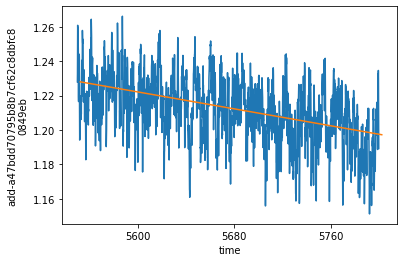

In [12]:
ds_control_timeseries.plot()#.coarsen(time=36, boundary='trim').mean()
trendline.plot()

We can remove this slope from either the control run 

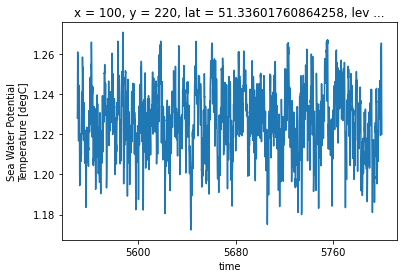

In [25]:
ds_control_timeseries_detrended = remove_trend(ds_control_timeseries, drift.thetao, ref_date=str(ds_control_timeseries.time.data[0]))
ds_control_timeseries_detrended.plot()

Sure thats nice, but that's not why we are here.

Lets remove the drift from 

In [15]:
ds_historical_timeseries = ds_historical.isel(**roi)
ds_historical_timeseries_detrended = remove_trend(ds_historical_timeseries.thetao, drift.thetao, ref_date=str(ds_historical.time.data[0]))

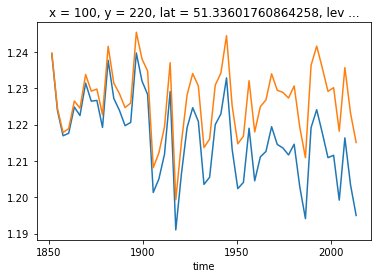

In [29]:
ds_historical_timeseries.thetao.coarsen(time=36).mean().plot()
ds_historical_timeseries_detrended.coarsen(time=36).mean().plot()

You can also remove the trend from the ssp585 scenario in a way that is consistent with the historical run. The key here is the `ref_date` input. 
This should be set to the 'branching' timestep of the historical run for both experiments (which is `1850-01-01` for most CMIP6 historical experiments). 

In [30]:
ds_ssp585_timeseries = ds_ssp585.isel(**roi)
ds_ssp585_timeseries_detrended = remove_trend(ds_ssp585_timeseries.thetao, drift.thetao, ref_date=str(ds_historical.time.data[0]))

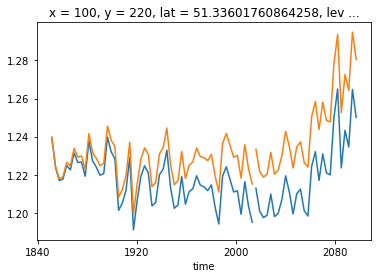

In [33]:
ds_historical_timeseries.thetao.coarsen(time=36, boundary='trim').mean().plot(color='C0', label='raw data')
ds_ssp585_timeseries.thetao.coarsen(time=36, boundary='trim').mean().plot(color='C0')
ds_historical_timeseries_detrended.coarsen(time=36, boundary='trim').mean().plot(color='C1', label='control drift removed')
ds_ssp585_timeseries_detrended.coarsen(time=36, boundary='trim').mean().plot(color='C1')

> You can do all this without selecting a single grid position, but it is recommended to rechunk the data first, since most CMIP6 data is chunked in time, making the linear regression difficult.

> We are working on calculating the linear trends for common variables and store them in the cloud. Then you only have to apply `remove_trend` and not the expensive `calculate_drift` anymore. Stay tuned!